<a href="https://colab.research.google.com/github/Fakerwws/MachineLearning_Python/blob/master/%E2%80%9CAlphaFold2_advanced_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlphaFold2_advanced

This notebook modifies deepmind's [original notebook](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) (**before AlphaFold-Multimer existed**) to add experimental support for modeling complexes (both homo and hetero-oligomers), option to run MMseqs2 instead of Jackhmmer for MSA generation and advanced functionality.

See [ColabFold](https://github.com/sokrypton/ColabFold/) for other related notebooks

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1) 

**Limitations**
- This notebook does **NOT** use Templates.
- This notebook does **NOT** use AlphaFold-Multimer for complex (protein-protein) modeling.
- For a typical Google-Colab session, with a `16G-GPU`, the max total length is **1400 residues**. Sometimes a `12G-GPU` is assigned, in which the max length is ~1000 residues.
- Can I use the models for **Molecular Replacement**? Yes, but be CAREFUL, the bfactor column is populated with pLDDT confidence values (higher = better). Phenix.phaser expects a "real" bfactor, where (lower = better). See [post](https://twitter.com/cheshireminima/status/1423929241675120643) from Claudia Millán on how to process models.

In [ ]:
#@title Install software
#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left.

# setup device
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook

from sys import version_info 
python_version = f"{version_info.major}.{version_info.minor}"

install_jackhmmer = True
GIT_REPO = 'https://github.com/deepmind/alphafold'
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  if not os.path.isdir("alphafold"):
    # download alphafold code
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")
    os.system(f"git clone https://github.com/sokrypton/ColabFold.git")

    # apply patches
    os.system(f"patch -u alphafold/alphafold/model/model.py -i ColabFold/beta/model.patch")
    os.system(f"patch -u alphafold/alphafold/model/mapping.py -i ColabFold/beta/mapping.patch")
    os.system(f"patch -u alphafold/alphafold/model/modules.py -i ColabFold/beta/modules.patch")
    os.system(f"patch -u alphafold/alphafold/model/folding.py -i ColabFold/beta/folding.patch")
    os.system(f"patch -u alphafold/alphafold/model/config.py -i ColabFold/beta/config.patch")
    # apply multi-chain patch from Lim Heo @huhlim
    os.system(f"patch -u alphafold/alphafold/common/protein.py -i ColabFold/beta/protein.patch")
    pbar.update(4)

    os.system(f"pip install biopython dm-haiku==0.0.5 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  else:
    pbar.update(55)

########################################################################################
# --- Python imports ---
if 'alphafold' not in sys.path:
  sys.path.append('alphafold')
if 'ColabFold/beta' not in sys.path:
  sys.path.append('ColabFold/beta')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

Running on GPU


  0%|          | 0/55 [elapsed: 00:00 remaining: ?]

In [ ]:
#@title Enter the amino acid sequence to fold ⬇️
import re

# define sequence
sequence = 'TSRDGYQWTPQSVIQPPTNITSDAVYDVIVVGAGYCGLTAARDATLAGLKVLLLEARDRIGGRSWSSNIDGYPFEMGGTWVHWGQPHVWREISRYQMRNEESSFDFSRGVNHFQLNTAQGSSMSHEEEDALLASALEKFVNVDGAYGRTIMPFPHDAFHVPEARKYDKMSVQDRIDQIASSLTSPNERAALEAFVLLCSGGTLETTSFFEFLHWWAMCGYTYQGCLDYLITYKFRGGQSSFAIRFFQEALSTGRLSYAFNSPVKSVKDQGGKVEVTTRDGRTYTAARLICTIPLNVLNTITFSPPLSPGKQAAMNIGHVNQCVKVHAEISNKDMRWTGISYPHNKLMYAIGDGTTAAAGNTHIVCFGASQNHIHPEEDIEETKKAVQNLAPGKMDIKRLVFHNWSKDEFAKGAWFFSPPGLLSEHLDDLRARHGNVLFANSDWAVGWRSFIDGAIEEGTRAAMTVKEELRKKRAVPRPRL' #@param {type:"string"}
jobname = "test282" #@param {type:"string"}
homooligomer =  "2" #@param {type:"string"}

#@markdown - `sequence` Specify protein sequence to be modelled.
#@markdown  - Use `/` to specify intra-protein chainbreaks (for trimming regions within protein).
#@markdown  - Use `:` to specify inter-protein chainbreaks (for modeling protein-protein hetero-complexes).
#@markdown  - For example, sequence `AC/DE:FGH` will be modelled as polypeptides: `AC`, `DE` and `FGH`. A seperate MSA will be generates for `ACDE` and `FGH`.
#@markdown    If `pair_msa` is enabled, `ACDE`'s MSA will be paired with `FGH`'s MSA.
#@markdown - `homooligomer` Define number of copies in a homo-oligomeric assembly.
#@markdown  - Use `:` to specify different homooligomeric state (copy numer) for each component of the complex. 
#@markdown  - For example, **sequence:**`ABC:DEF`, **homooligomer:** `2:1`, the first protein `ABC` will be modeled as a homodimer (2 copies) and second `DEF` a monomer (1 copy).

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)

homooligomer: 2
total_length: 960
output_dir: prediction_test282_52310


running mmseqs2


  0%|          | 0/150 [elapsed: 00:00 remaining: ?]

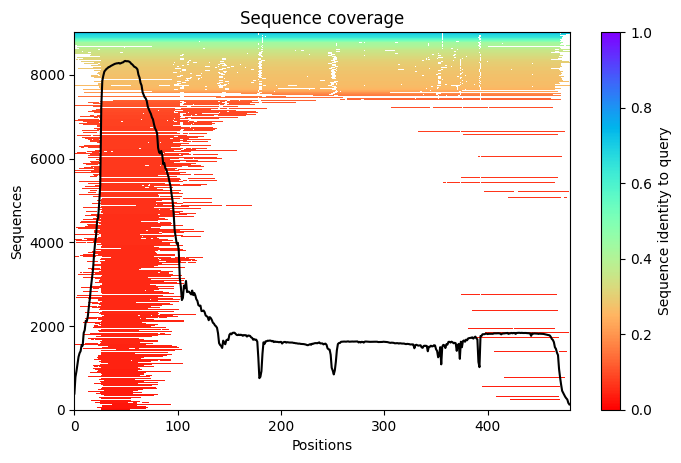

In [ ]:
#@title Search against genetic databases
#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment 
#@markdown (MSA) that will be used by AlphaFold. In particular, 
#@markdown you’ll see how well each residue is covered by similar 
#@markdown sequences in the MSA.
#@markdown (Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.)

#@markdown ---
msa_method = "mmseqs2" #@param ["mmseqs2","jackhmmer","single_sequence","precomputed"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold)
#@markdown - `jackhmmer` - default method from Deepmind (SLOW, but may find more/less sequences).
#@markdown - `single_sequence` - use single sequence input
#@markdown - `precomputed` If you have previously run this notebook and saved the results,
#@markdown you can skip this step by uploading 
#@markdown the previously generated  `prediction_?????/msa.pickle`


#@markdown ---
#@markdown **custom msa options**
add_custom_msa = False #@param {type:"boolean"}
msa_format = "fas" #@param ["fas","a2m","a3m","sto","psi","clu"]
#@markdown - `add_custom_msa` - If enabled, you'll get an option to upload your custom MSA in the specified `msa_format`. Note: Your MSA will be supplemented with those from 'mmseqs2' or 'jackhmmer', unless `msa_method` is set to 'single_sequence'.

#@markdown ---
#@markdown **pair msa options**

#@markdown Experimental option for protein complexes. Pairing currently only supported for proteins in same operon (prokaryotic genomes).
pair_mode = "unpaired" #@param ["unpaired","unpaired+paired","paired"] {type:"string"}
#@markdown - `unpaired` - generate seperate MSA for each protein.
#@markdown - `unpaired+paired` - attempt to pair sequences from the same operon within the genome. 
#@markdown - `paired` - only use sequences that were sucessfully paired.

#@markdown Options to prefilter each MSA before pairing. (It might help if there are any paralogs in the complex.)
pair_cov = 50 #@param [0,25,50,75,90] {type:"raw"}
pair_qid = 20 #@param [0,15,20,30,40,50] {type:"raw"}
#@markdown - `pair_cov` prefilter each MSA to minimum coverage with query (%) before pairing.
#@markdown - `pair_qid` prefilter each MSA to minimum sequence identity with query (%) before pairing.

# --- Search against genetic databases ---

I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I

if len(I["msas"][0]) > 1:
  plt = cf.plot_msas(I["msas"], I["ori_sequence"])
  plt.savefig(os.path.join(I["output_dir"],"msa_coverage.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

In [ ]:
#@title Filter options (optional)
trim = "" #@param {type:"string"}
trim_inverse = False #@param {type:"boolean"}
#@markdown - Use `trim` to specify regions to trim. For example: `trim:5-9,20` will remove positions 5,6,7,8,9 and 20. 
#@markdown  - For complexes, you can use `trim:A1-A3,B5-B7` to remove positions 1,2,3 in 1st protein and positions 5,6,7 in 2nd protein.
#@markdown  - Note: This function is 1-indexed, meaning the first position is 1, not 0.
#@markdown  - To specify regions to keep instead of trim, enable `trim_inverse`
cov = 0 #@param [0,25,50,75,90,95] {type:"raw"}
qid = 0 #@param [0,15,20,25,30,40,50] {type:"raw"}
#@markdown - `cov` minimum coverage with query (%)
#@markdown - `qid` minimum sequence identity with query (%)

mod_I = cf_af.prep_filter(I, trim, trim_inverse, cov, qid)

if I["msas"] != mod_I["msas"]:
  plt.figure(figsize=(16,5),dpi=100)
  plt.subplot(1,2,1)
  plt.title("Sequence coverage (Before)")
  cf.plot_msas(I["msas"], I["ori_sequence"], return_plt=False)
  plt.subplot(1,2,2)
  plt.title("Sequence coverage (After)")
  cf.plot_msas(mod_I["msas"], mod_I["ori_sequence"], return_plt=False)
  plt.savefig(os.path.join(I["output_dir"],"msa_coverage.filtered.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

  0%|          | 0/5 [elapsed: 00:00 remaining: ?]

model_1_ptm_seed_0 recycles:3 tol:0.00 pLDDT:91.12 pTMscore:0.91


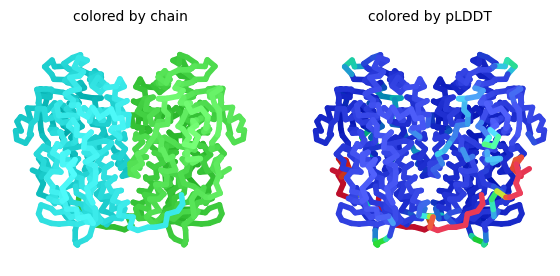

model_2_ptm_seed_0 recycles:3 tol:0.00 pLDDT:91.56 pTMscore:0.92


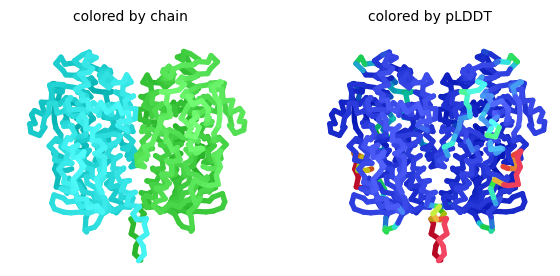

model_3_ptm_seed_0 recycles:3 tol:0.00 pLDDT:92.26 pTMscore:0.93


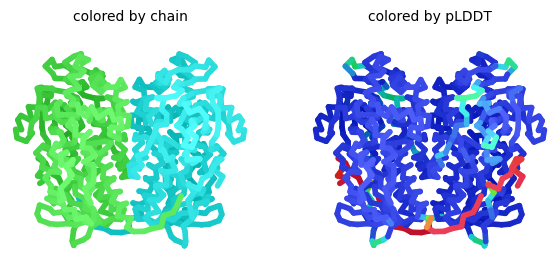

model_4_ptm_seed_0 recycles:3 tol:0.00 pLDDT:92.72 pTMscore:0.93


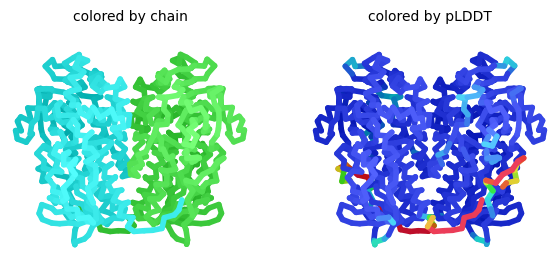

model_5_ptm_seed_0 recycles:3 tol:0.00 pLDDT:92.38 pTMscore:0.93


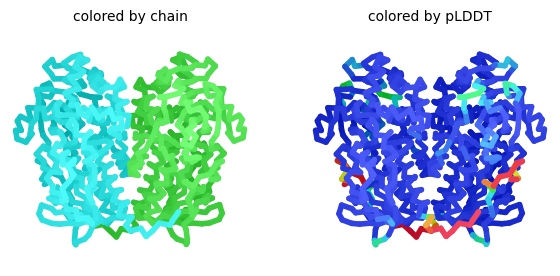

model rank based on pLDDT
rank_1_model_4_ptm_seed_0 pLDDT:92.72
rank_2_model_5_ptm_seed_0 pLDDT:92.38
rank_3_model_3_ptm_seed_0 pLDDT:92.26
rank_4_model_2_ptm_seed_0 pLDDT:91.56
rank_5_model_1_ptm_seed_0 pLDDT:91.12


In [ ]:
#@title Run alphafold
num_relax = "None"
rank_by = "pLDDT" #@param ["pLDDT","pTMscore"]
use_turbo = True #@param {type:"boolean"}
max_msa = "512:1024" #@param ["512:1024", "256:512", "128:256", "64:128", "32:64"]
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]

#@markdown - `rank_by` specify metric to use for ranking models (For protein-protein complexes, we recommend pTMscore)
#@markdown - `use_turbo` introduces a few modifications (compile once, swap params, adjust max_msa) to speedup and reduce memory requirements. Disable for default behavior.
#@markdown - `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. When adjusting after GPU crash, be sure to `Runtime` → `Restart runtime`. (Lowering will reduce GPU requirements, but may result in poor model quality. This option ignored if `use_turbo` is disabled)
show_images = True #@param {type:"boolean"}
#@markdown - `show_images` To make things more exciting we show images of the predicted structures as they are being generated. (WARNING: the order of images displayed does not reflect any ranking).

#@markdown ---
#@markdown **sampling options**

#@markdown There are two stochastic parts of the pipeline. Within the feature generation (choice of cluster centers) and within the model (dropout). 
#@markdown To get structure diversity, you can iterate through a fixed number of random_seeds (using `num_samples`) and/or enable dropout (using `is_training`).

num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
use_ptm = True #@param {type:"boolean"}
num_ensemble = 1 #@param [1,2,4,8] {type:"raw"}
max_recycles = 3 #@param [0,1,3,6,12,24,48] {type:"raw"}
is_training = False #@param {type:"boolean"}
num_samples = 1 #@param [1,2,4,8,16,32] {type:"raw"}
#@markdown - `num_models` specify how many model params to try. (5 recommended)
#@markdown - `use_ptm` uses Deepmind's `ptm` finetuned model parameters to get PAE per structure. Disable to use the original model params. (Disabling may give alternative structures.)
#@markdown - `num_ensemble` the trunk of the network is run multiple times with different random choices for the MSA cluster centers. (`1`=`default`, `8`=`casp14 setting`)
#@markdown - `max_recycles` controls the maximum number of times the structure is fed back into the neural network for refinement. (3 recommended)
#@markdown - `is_training` enables the stochastic part of the model (dropout), when coupled with `num_samples` can be used to "sample" a diverse set of structures.
#@markdown - `num_samples` number of random_seeds to try.
subsample_msa = True #@param {type:"boolean"}
#@markdown - `subsample_msa` subsample large MSA to `3E7/length` sequences to avoid crashing the preprocessing protocol. (This option ignored if `use_turbo` is disabled.)

if not use_ptm and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

# prep input features
feature_dict = cf_af.prep_feats(mod_I, clean=IN_COLAB)
Ls_plot = feature_dict["Ls"]

# prep model options
opt = {"N":len(feature_dict["msa"]),
       "L":len(feature_dict["residue_index"]),
       "use_ptm":use_ptm,
       "use_turbo":use_turbo,
       "max_recycles":max_recycles,
       "tol":0.0,
       "num_ensemble":num_ensemble,
       "max_msa_clusters":max_msa_clusters,
       "max_extra_msa":max_extra_msa,
       "is_training":is_training}

if use_turbo:
  if "runner" in dir():
    # only recompile if options changed
    runner = cf_af.prep_model_runner(opt, old_runner=runner)
  else:
    runner = cf_af.prep_model_runner(opt)
else:
  runner = None

###########################
# run alphafold
###########################
outs, model_rank = cf_af.run_alphafold(feature_dict, opt, runner, num_models, num_samples, subsample_msa,
                                       rank_by=rank_by, show_images=show_images)


In [ ]:
#@title Refine structures with Amber-Relax (optional)
#@markdown If side-chain bond geometry is important to you, enable Amber-Relax by specifying how many top ranked structures you want relaxed. By default, we disable Amber-Relax since it barely moves the main-chain (backbone) structure and can overall double the runtime.
num_relax = "None" #@param ["None", "Top1", "Top5", "All"] {type:"string"}
if num_relax == "None":
  num_relax = 0
elif num_relax == "Top1":
  num_relax = 1
elif num_relax == "Top5":
  num_relax = 5
else:
  num_relax = num_models * num_samples

#@markdown - `num_relax` specify how many of the top ranked structures to relax
if num_relax > 0 and not os.path.isfile("stereo_chemical_props.txt"):
  try:
    total = 45
    with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
      pbar.set_description(f'INSTALL AMBER')
      with io.capture_output() as captured:
        # Install OpenMM and pdbfixer.
        %shell rm -rf /opt/conda
        %shell wget -q -P /tmp \
          https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh \
            && bash /tmp/Miniconda3-latest-Linux-x86_64.sh -b -p /opt/conda \
            && rm /tmp/Miniconda3-latest-Linux-x86_64.sh
        pbar.update(4)

        PATH=%env PATH
        %env PATH=/opt/conda/bin:{PATH}
        %shell conda install -qy conda==4.13.0 \
            && conda install -qy -c conda-forge \
              python={python_version} \
              openmm=7.5.1 \
              pdbfixer
        pbar.update(40)

        %shell wget -q -P /content \
          https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
        pbar.update(1)
        %shell mkdir -p /content/alphafold/common
        %shell cp -f /content/stereo_chemical_props.txt /content/alphafold/common

        # Apply OpenMM patch.
        %shell pushd /opt/conda/lib/python{python_version}/site-packages/ && \
            patch -p0 < /content/alphafold/docker/openmm.patch && \
            popd

  except subprocess.CalledProcessError:
    print(captured)
    raise

if num_relax > 0:
  if "relax" not in dir():
    # add conda environment to path
    sys.path.append(f"/opt/conda/lib/python{python_version}/site-packages")
    if 'LC_ALL' in os.environ:
      del os.environ['LC_ALL']
    
    # import libraries
    from alphafold.relax import relax
    from alphafold.relax import utils

  with tqdm.notebook.tqdm(total=num_relax, bar_format=TQDM_BAR_FORMAT) as pbar:
    pbar.set_description(f'AMBER relaxation')
    for n,key in enumerate(model_rank):
      if n < num_relax:
        prefix = f"rank_{n+1}_{key}" 
        pred_output_path = os.path.join(I["output_dir"],f'{prefix}_relaxed.pdb')
        if not os.path.isfile(pred_output_path):
          amber_relaxer = relax.AmberRelaxation(
              max_iterations=0,
              tolerance=2.39,
              stiffness=10.0,
              exclude_residues=[],
              max_outer_iterations=20)
          relaxed_pdb_lines, _, _ = amber_relaxer.process(prot=outs[key]["unrelaxed_protein"])        
          with open(pred_output_path, 'w') as f:
            f.write(relaxed_pdb_lines)
        pbar.update(n=1)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

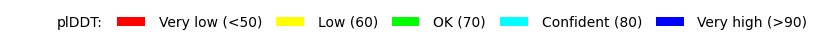

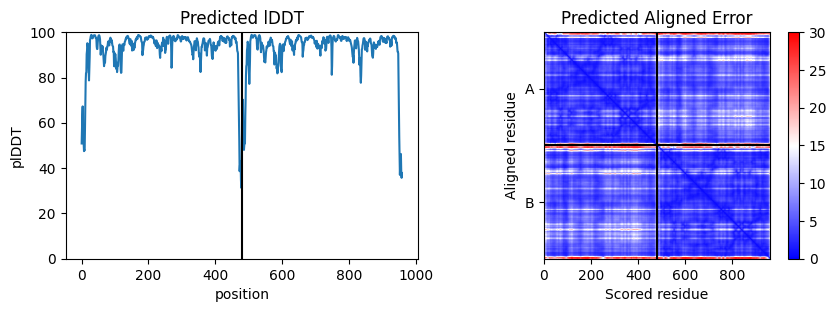

In [ ]:
#@title Display 3D structure (optional) {run: "auto"}
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

key = model_rank[rank_num-1]
prefix = f"rank_{rank_num}_{key}" 
pred_output_path = os.path.join(I["output_dir"],f'{prefix}_relaxed.pdb')  
if not os.path.isfile(pred_output_path):
  pred_output_path = os.path.join(I["output_dir"],f'{prefix}_unrelaxed.pdb') 

cf.show_pdb(pred_output_path, show_sidechains, show_mainchains, color, Ls=Ls_plot).show()
if color == "lDDT": cf.plot_plddt_legend().show()  
if use_ptm:
  cf.plot_confidence(outs[key]["plddt"], outs[key]["pae"], Ls=Ls_plot).show()
else:
  cf.plot_confidence(outs[key]["plddt"], Ls=Ls_plot).show()

predicted alignment error


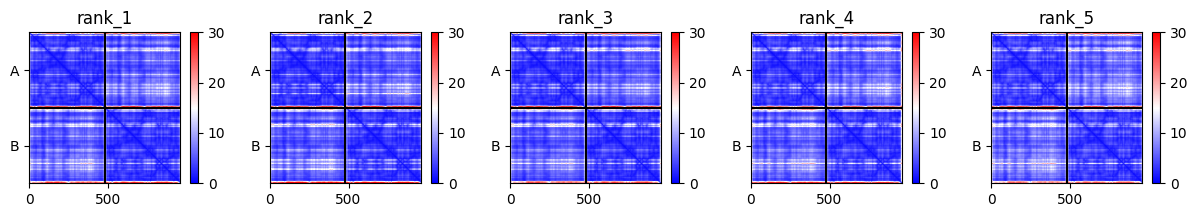

predicted contacts


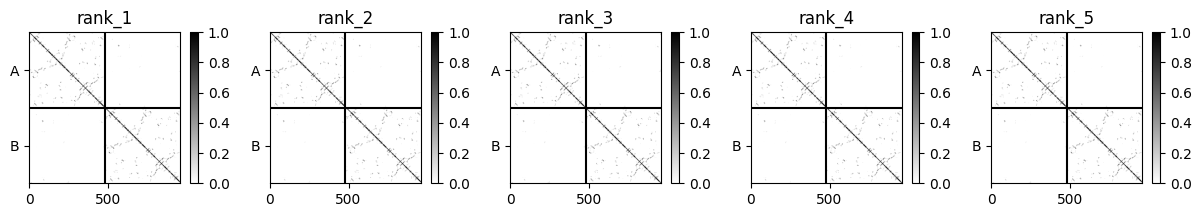

predicted distogram


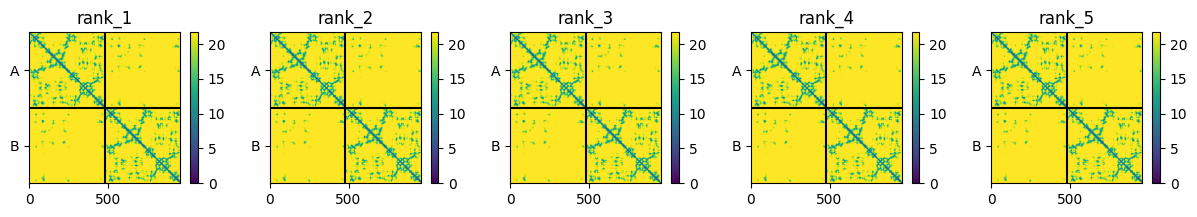

predicted LDDT


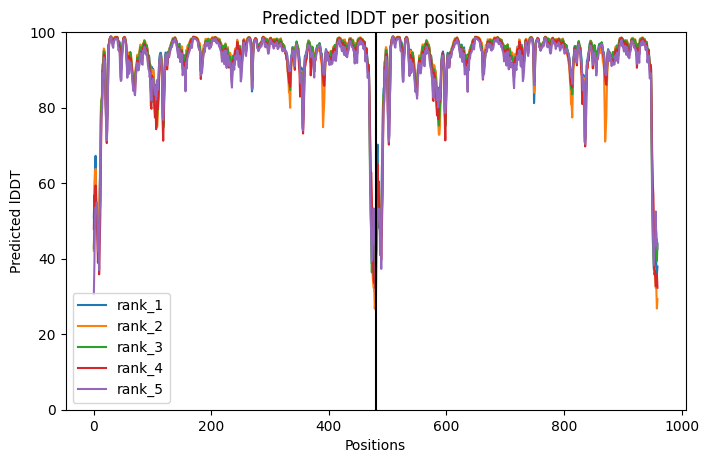

In [ ]:
#@title Extra outputs (optional)
dpi =  100#@param {type:"integer"}
save_to_txt = True #@param {type:"boolean"}
save_pae_json = True #@param {type:"boolean"}
#@markdown - save data used to generate contact and distogram plots below to text file (pae values can be found in json file if `use_ptm` is enabled)

if use_ptm:
  print("predicted alignment error")
  cf.plot_paes([outs[k]["pae"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
  plt.savefig(os.path.join(I["output_dir"],f'predicted_alignment_error.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
  plt.show()

print("predicted contacts")
cf.plot_adjs([outs[k]["adj"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(I["output_dir"],f'predicted_contacts.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted distogram")
cf.plot_dists([outs[k]["dists"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(I["output_dir"],f'predicted_distogram.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

print("predicted LDDT")
cf.plot_plddts([outs[k]["plddt"] for k in model_rank], Ls=Ls_plot, dpi=dpi)
plt.savefig(os.path.join(I["output_dir"],f'predicted_LDDT.png'), bbox_inches = 'tight', dpi=np.maximum(200,dpi))
plt.show()

def do_save_to_txt(filename, adj, dists, sequence):
  adj = np.asarray(adj)
  dists = np.asarray(dists)
  L = len(adj)
  with open(filename,"w") as out:
    out.write("i\tj\taa_i\taa_j\tp(cbcb<8)\tmaxdistbin\n")
    for i in range(L):
      for j in range(i+1,L):
        if dists[i][j] < 21.68 or adj[i][j] >= 0.001:
          line = f"{i}\t{j}\t{sequence[i]}\t{sequence[j]}\t{adj[i][j]:.3f}"
          line += f"\t>{dists[i][j]:.2f}" if dists[i][j] == 21.6875 else f"\t{dists[i][j]:.2f}"
          out.write(f"{line}\n")

for n,key in enumerate(model_rank):
  if save_to_txt:
    txt_filename = os.path.join(I["output_dir"],f'rank_{n+1}_{key}.raw.txt')
    do_save_to_txt(txt_filename,
                   outs[key]["adj"],
                   outs[key]["dists"],
                   mod_I["full_sequence"])

  if use_ptm and save_pae_json:
    pae = outs[key]["pae"]
    max_pae = pae.max()
    # Save pLDDT and predicted aligned error (if it exists)
    pae_output_path = os.path.join(I["output_dir"],f'rank_{n+1}_{key}_pae.json')
    # Save predicted aligned error in the same format as the AF EMBL DB
    rounded_errors = np.round(np.asarray(pae), decimals=1)
    indices = np.indices((len(rounded_errors), len(rounded_errors))) + 1
    indices_1 = indices[0].flatten().tolist()
    indices_2 = indices[1].flatten().tolist()
    pae_data = json.dumps([{
        'residue1': indices_1,
        'residue2': indices_2,
        'distance': rounded_errors.flatten().tolist(),
        'max_predicted_aligned_error': max_pae.item()
    }],
                          indent=None,
                          separators=(',', ':'))
    with open(pae_output_path, 'w') as f:
      f.write(pae_data)

In [ ]:
#@title Animate outputs (optional)
dpi =  100#@param {type:"integer"}
use_pca = True #@param {type:"boolean"}
color_by_plddt = False #@param {type:"boolean"}
#@markdown - `use_pca` - use the first principle component to determine order of animation frames


import matplotlib
from matplotlib import animation
from IPython.display import HTML
from sklearn.decomposition import PCA

def mk_animation(positions, labels, plddt, ref=0, Ls=None, line_w=2.0, dpi=100,color_by_plddt=False):

  def ca_align_to_last(positions, ref):
    def align(P, Q):
      if Ls is None or len(Ls) == 1:
        P_,Q_ = P,Q
      else:
        # align relative to first chain
        P_,Q_ = P[:Ls[0]],Q[:Ls[0]]
      p = P_ - P_.mean(0,keepdims=True)
      q = Q_ - Q_.mean(0,keepdims=True)
      return ((P - P_.mean(0,keepdims=True)) @ cf.kabsch(p,q)) + Q_.mean(0,keepdims=True)
    
    pos = positions[ref,:,1,:] - positions[ref,:,1,:].mean(0,keepdims=True)
    best_2D_view = pos @ cf.kabsch(pos,pos,return_v=True)

    new_positions = []
    for i in range(len(positions)):
      new_positions.append(align(positions[i,:,1,:],best_2D_view))
    return np.asarray(new_positions)

  # align to reference 
  pos = ca_align_to_last(positions, ref)

  fig, (ax1) = plt.subplots(1)
  fig.set_figwidth(5)
  fig.set_figheight(5)
  fig.set_dpi(dpi)

  xy_min = pos[...,:2].min() - 1
  xy_max = pos[...,:2].max() + 1

  for ax in [ax1]:
    ax.set_xlim(xy_min, xy_max)
    ax.set_ylim(xy_min, xy_max)
    ax.axis(False)

  ims=[]
  for l,pos_,plddt_ in zip(labels,pos,plddt):
    if color_by_plddt:
      img = cf.plot_pseudo_3D(pos_, c=plddt_, cmin=50, cmax=90, line_w=line_w, ax=ax1)    
    elif Ls is None or len(Ls) == 1:
      img = cf.plot_pseudo_3D(pos_, ax=ax1, line_w=line_w)
    else:
      c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
      img = cf.plot_pseudo_3D(pos_, c=c, cmap=cf.pymol_cmap, cmin=0, cmax=39, line_w=line_w, ax=ax1)
    ims.append([cf.add_text(f"{l}", ax1),img])
    
  ani = animation.ArtistAnimation(fig, ims, blit=True, interval=120)
  plt.close()
  return ani.to_html5_video()

labels = np.array([k for k in outs])
pos = np.array([outs[k]["unrelaxed_protein"].atom_positions for k in labels])
plddt = np.asarray([outs[k]["plddt"] for k in outs.keys()])
if use_pca:
  pos_ca = pos[:,:,1,:]
  if Ls_plot is not None and len(Ls_plot) > 1:
    pos_ca = pos_ca[:,:Ls_plot[0]]
  i,j = np.triu_indices(pos_ca.shape[1],k=1)
  pos_ca_dm = np.sqrt(np.square(pos_ca[:,None,:,:] - pos_ca[:,:,None]).sum(-1))[:,i,j]
  pc = PCA(1).fit_transform(pos_ca_dm)[:,0].argsort()
  pos = pos[pc]
  labels = labels[pc]
  plddt = plddt[pc]

HTML(mk_animation(pos, labels, plddt, Ls=Ls_plot, dpi=dpi, color_by_plddt=color_by_plddt))

In [ ]:
#@title Download prediction

#@markdown Once this cell has been executed, a zip-archive with 
#@markdown the obtained prediction will be automatically downloaded 
#@markdown to your computer.

# add settings file
settings_path = os.path.join(I["output_dir"],"settings.txt")
with open(settings_path, "w") as text_file:
  text_file.write(f"notebook=https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/beta/AlphaFold2_advanced_beta.ipynb\n")
  text_file.write(f"sequence={I['ori_sequence']}\n")
  text_file.write(f"msa_method={msa_method}\n")
  if add_custom_msa:
    text_file.write(f"add_custom_msa={add_custom_msa} msa_format={msa_format}\n")
  text_file.write(f"homooligomer={I['homooligomer']}\n")

  text_file.write(f"pair_mode={pair_mode}\n")
  if pair_mode != "unpaired":
    text_file.write(f"pair_cov={pair_cov}\n")
    text_file.write(f"pair_qid={pair_qid}\n")
  
  if I["ori_sequence"] != mod_I["ori_sequence"]:
    text_file.write(f"mod_sequence={mod_I['ori_sequence']}\n")
    text_file.write(f"trim={trim}\n")
    text_file.write(f"trim_inverse={trim_inverse}\n")
  
  if "cov" in dir():
    text_file.write(f"cov={cov}\n")
    text_file.write(f"qid={qid}\n")
  else:
    text_file.write(f"cov=0\nqid=0\n")

  text_file.write(f"max_msa={max_msa}\n")
  text_file.write(f"subsample_msa={subsample_msa}\n")  
  text_file.write(f"num_relax={num_relax}\n")
  text_file.write(f"use_turbo={use_turbo}\n")
  text_file.write(f"use_ptm={use_ptm}\n")
  text_file.write(f"rank_by={rank_by}\n")
  text_file.write(f"num_models={num_models}\n")
  text_file.write(f"num_samples={num_samples}\n")
  text_file.write(f"num_ensemble={num_ensemble}\n")
  text_file.write(f"max_recycles={max_recycles}\n")
  text_file.write(f"is_training={is_training}\n")
  text_file.write(f"use_templates=False\n")
  text_file.write(f"-------------------------------------------------\n")

  for n,key in enumerate(model_rank):
    line = f"rank_{n+1}_{key} pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    text_file.write(line+"\n")

# --- Download the predictions ---
os.system(f'zip -FSr {I["output_dir"]}.zip {I["output_dir"]}')
if IN_COLAB:
  files.download(f'{I["output_dir"]}.zip')
else:
  print("this notebook appears to be running locally, to download click folder icon to the left, navigate to file, right click and download")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# License

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).